In [82]:
import numpy as np
from astropy import units as u
from matplotlib import pyplot as plt
%matplotlib inline

In [136]:
@u.quantity_input
def differential_flux(energy: u.TeV, norm: 1/(u.TeV * u.s * u.m**2), index):
    return norm * energy.to_value(u.TeV) ** index

In [25]:
@u.quantity_input
def integrate(e_min: u.TeV, e_max: u.TeV, norm: 1/(u.TeV * u.s * u.m**2), index):
    a = e_min.to_value('TeV')
    b = e_max.to_value('TeV')
    norm_ = norm.to(1 / (u.TeV * u.s * u.m**2)) * u.TeV
    return norm_ * (1 / (index + 1)) * (b**(index + 1) - a**(index + 1))

In [143]:
@u.quantity_input
def observation_time(e_min: u.TeV, e_max: u.TeV, area:u.m**2, norm: 1/(u.TeV * u.s * u.m**2), index, n_events):
    return (n_events / (integrate(e_min, e_max, norm, index) * area)).to(u.s)

In [87]:
@u.quantity_input
def expected_events(e_min: u.TeV, e_max: u.TeV, area:u.m**2, norm: 1/(u.TeV * u.s * u.m**2), index, t_obs: u.s):
    return (integrate(e_min, e_max, norm, index) * area * t_obs).si.value

In [102]:
@u.quantity_input
def expected_events_for_bins(energy_bins: u.TeV, area:u.m**2, norm: 1/(u.TeV * u.s * u.m**2), index, t_obs: u.s):
    return np.array([expected_events(l, h, area, norm, index, t_obs) for (l, h) in zip(energy_bins[0:], energy_bins[1:])])

In [103]:
@u.quantity_input
def sample(e_min: u.TeV, e_max: u.TeV, index, size):
    a = e_min.to_value('TeV') ** (index + 1)
    b = e_max.to_value('TeV') ** (index + 1)
    r = np.random.uniform(0, 1, size)
    k = (a + (b - a) * r)
    e = k ** (1. / (index + 1))
    return u.Quantity(e, u.TeV, copy=False)

In [104]:
@u.quantity_input
def make_energy_bins(e_min: u.TeV, e_max: u.TeV, bins=10):
    unit = e_min.unit
    low = np.log10(e_min.value)
    high = np.log10(e_max.value)
    bin_edges = np.logspace(low, high, endpoint=True, num=bins + 1) * unit
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    bin_widths = np.diff(bin_edges)
    return bin_edges, bin_centers, bin_widths

In [105]:
energy_bins, bin_center, bin_width = make_energy_bins(e_min=e_min, e_max=e_max, bins=20)

In [106]:
e_min = 0.003 * u.TeV 
e_max = 300 * u.TeV   
area = 1 * u.km**2    

crab_norm = u.Quantity(2.83e-14, 1/(u.GeV * u.cm**2 * u.s), copy=False)
crab_index = -2.62

# Lets say we observe the crab for 1 hour
t_obs = 1 * u.h
n_events = expected_events(e_min, e_max, area, crab_norm, crab_index, t_obs)
print(f"{n_events} events observed when observing the crab for {t_obs}")
obs_events = sample(e_min, e_max, crab_index, int(n_events))
obs_binned_events = expected_events_for_bins(energy_bins, area, crab_norm, crab_index, t_obs)

7684886.994993243 events observed when observing the crab for 1.0 h


In [98]:
# Define simulation spectrum
mc_index = -2
n_mc_events = 100000
# Set MC spectrum normalisation such that it gives us the correct number of events
N = integrate(e_min, e_max, 1/(u.TeV * u.s * u.m**2), mc_index) * area * 1*u.s
mc_norm = (n_mc_events / N).si.value / (u.TeV * u.m**2 * u.s)

# Now lets run our simulation
mc_events = sample(e_min, e_max, mc_index, n_mc_events)

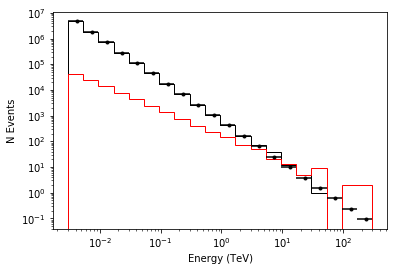

In [138]:
plt.errorbar(
    bin_center.value, obs_binned_events, xerr=bin_width.value * 0.5,
    linestyle='', marker='.', label='expected events from crab', color='black',
)
plt.hist(obs_events, energy_bins, histtype='step', color='black')
plt.hist(mc_events, energy_bins, histtype='step', color='red')
plt.xlabel("Energy (TeV)")
plt.ylabel("N Events")
plt.xscale('log')
plt.yscale('log')

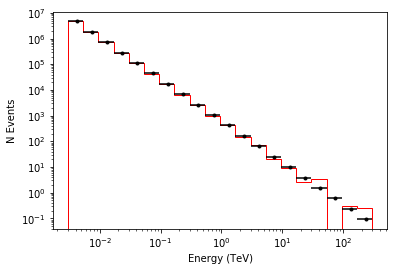

In [140]:
# We wish to reweigh our MC simulated events such that they match the Crab Spectrum
n_mc_events_expected = expected_events(e_min, e_max, area, mc_norm, mc_index, t_obs)
crab_flux = differential_flux(mc_events, crab_norm, crab_index)
mc_flux = differential_flux(mc_events, mc_norm, mc_index)
weights = (n_mc_events_expected / n_mc_events) * (crab_flux / mc_flux).si.value

plt.errorbar(
    bin_center.value, obs_binned_events, xerr=bin_width.value * 0.5,
    linestyle='', marker='.', label='expected events from crab', color='black',
)
plt.hist(mc_events, energy_bins, weights=weights, histtype='step', color='red')
plt.xlabel("Energy (TeV)")
plt.ylabel("N Events")
plt.xscale('log')
plt.yscale('log')

/Users/Jason/anaconda3/envs/cta/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


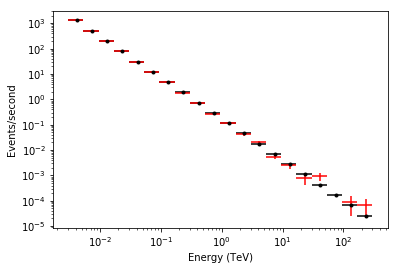

In [190]:
# Now lets try Sabrina's weighting, and expression in terms of events per second
T_mc = n_mc_events * (mc_index + 1)
T_mc = T_mc / area
emax = e_max.to('TeV') / u.TeV
emin = e_min.to('TeV') / u.TeV
T_mc = T_mc / (emax**(mc_index + 1) - emin**(mc_index + 1))
norm = crab_norm.to(1 / (u.TeV * u.s * u.m**2)) * u.TeV
T_mc = T_mc / norm
T_mc = T_mc.to_value(u.s)
# NOTE: The crab normalisation is used here! Not the MC norm

weights = mc_events.to_value(u.TeV) ** (-mc_index + crab_index)

hist_mc, bin_edges = np.histogram(mc_events, weights=weights, bins=energy_bins)
hist_mc_err, _ = np.histogram(mc_events, bins=energy_bins)
bin_mids = (bin_edges[1:] + bin_edges[:-1]) * 0.5

plt.errorbar(
    bin_center.value, obs_binned_events/t_obs.to_value(u.s), xerr=bin_width.value * 0.5,
    linestyle='', marker='.', label='expected events from crab', color='black',
)
plt.errorbar(
    bin_mids, hist_mc/T_mc, 
    (hist_mc / hist_mc_err) * np.sqrt(hist_mc_err)/T_mc, 
    np.diff(bin_edges) * 0.5, 
    linestyle='', color='red'
)
plt.xlabel("Energy (TeV)")
plt.ylabel("Events/second")
plt.xscale('log')
plt.yscale('log')